# ImageCLEF plant dataset preprocessing

In [5]:
## If you get an error "ImportError : No module named cv2, install opencv with
##   conda install opencv
import cv2
import os
import numpy as np
import numpy.ma as ma
import pylab as pl
import pandas as pd
import matplotlib.cm as cm
import skimage
import skimage.io
import skimage.color
import skimage.transform
import skimage.morphology
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [8]:
TRAIN_PATH = 'data_full/FourniApresCLEF2012/data/train'

train_files = [os.path.splitext(f)[0] for f in os.listdir(TRAIN_PATH) if f.endswith('.jpg')]
print len(train_files)

8422


In [9]:
(4000 * 512 * 512 * 3 * 4) / (1024.0 * 1024 * 1024), 'gb'

(11.71875, 'gb')

## Segmentation

For segmentation, we *assume* that the color in the corners gives the background color.

Not all images have the same size, but they have a maximum height/width of 800.

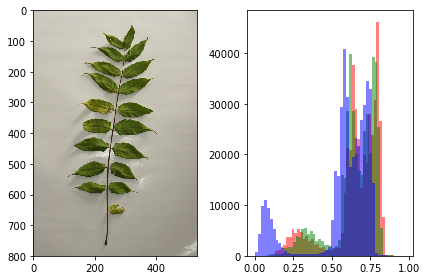

In [10]:
img = skimage.io.imread(os.path.join(TRAIN_PATH, '3142.jpg'))
img = skimage.img_as_float(img)

pl.subplot(121)
pl.imshow(img)
pl.subplot(122)
_ = pl.hist(img[:,:,0].flat, color='r', bins=50, alpha=0.5)
_ = pl.hist(img[:,:,1].flat, color='g', bins=50, alpha=0.5)
_ = pl.hist(img[:,:,2].flat, color='b', bins=50, alpha=0.5)
pl.tight_layout()

/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


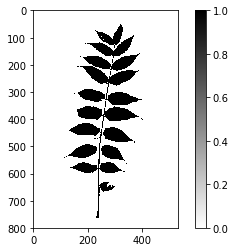

In [11]:
def extract_background(img, plot=False):
    img_lab = skimage.color.rgb2lab(img)
    
    corners_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.bool)
    corner_per = 0.1 # percentage of the width/height considered a corner
    imwidth = img.shape[1]
    imheight = img.shape[0]
    corners_mask[0:imheight*corner_per, 0:imwidth*corner_per] = True
    corners_mask[0:imheight*corner_per, imwidth*(1-corner_per):imwidth] = True
    corners_mask[imheight*(1-corner_per):imheight, 0:imwidth*corner_per] = True
    corners_mask[imheight*(1-corner_per):imheight, imwidth*(1-corner_per):imwidth] = True

    colors = img_lab[corners_mask]

    # Simply thresholding on the distance to average background color
    bg_color = np.mean(colors, axis=0)

    X_lab = img_lab.reshape(-1, 3)
    distimg = np.sqrt(np.sum((X_lab - np.tile(bg_color, (X_lab.shape[0], 1)))**2, axis=1))
    distimg = distimg.reshape((img.shape[0], img.shape[1]))

    dist_thresh = 20
    fgmask = distimg > dist_thresh
    
    # erode the border to avoid whiteish border
    #se = skimage.morphology.disk(2)
    #fgmask = skimage.morphology.binary_erosion(fgmask, se) == 1
    
    if plot:
        #pl.imshow(distimg)
        pl.imshow(fgmask, cmap=cm.binary)
        pl.colorbar()

    fgimg = ma.masked_all(img.shape, dtype=np.float32)
    fgimg[fgmask] = img[fgmask]
    return fgimg

fgimg = extract_background(img, plot=True)

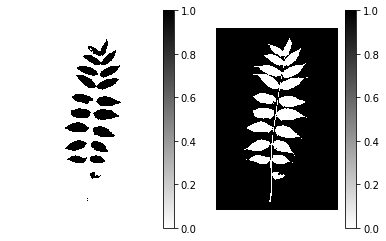

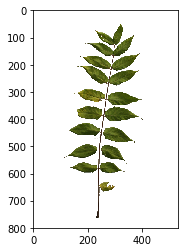

In [12]:
def remove_small_objects(img, plot=False):
    """This has a tendency to remove the branches, which is not good..."""
    # clean the mask (remove small objects) using morphology reconstruction
    mask = skimage.img_as_ubyte(np.all(~img.mask, axis=2))

    se = skimage.morphology.disk(3)
    marker = skimage.morphology.binary_erosion(mask, se)

    clean_mask = skimage.morphology.reconstruction(seed=marker, mask=mask)
    clean_mask = clean_mask < 0.01
    
    outimg = img.copy()
    for i in xrange(3):
        outimg.mask[:,:,i] = clean_mask

    if plot:
        pl.subplot(121)
        pl.imshow(marker, cmap=cm.binary)
        pl.axis('off')
        pl.colorbar()
        pl.subplot(122)
        pl.imshow(clean_mask, cmap=cm.binary)
        pl.colorbar()
        pl.axis('off')

        # display image with new mask on white background
        pl.figure()
        pl.imshow(fgimg.filled(1))
        
    return outimg

fgimg = remove_small_objects(fgimg, plot=True)

## Image width & height standardization

We will start by transforming all images so they have the same height & width. We crop input images to the foreground region.

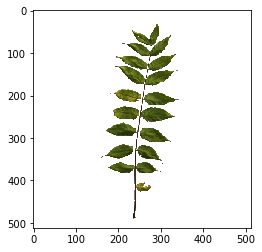

In [13]:
def resize_to_square(img, target_size=512, plot=False):
    # We resize the image by downsizing to a square that will fit target_size
    outimg = ma.masked_all((target_size, target_size, 3), dtype=np.float32)

    if img.shape[0] > img.shape[1]:
        ratio = target_size / float(img.shape[0])
    else:
        ratio = target_size / float(img.shape[1])

    resize_size = np.array((int(img.shape[0] * ratio), int(img.shape[1] * ratio)))
    margins = (target_size - resize_size) / 2

    # use nearest neighbor interpolation to avoid artifacts
    resized_img = cv2.resize(img.filled(-1), (resize_size[1], resize_size[0]),
                             interpolation=cv2.INTER_NEAREST)
    outimg[margins[0]:margins[0]+resize_size[0], margins[1]:margins[1]+resize_size[1], :] = resized_img
        
    # Recompute the mask so all 3 channels have the same mask
    all_mask = np.any(outimg.filled(-1) == -1, axis=2)
    for i in xrange(3):
        outimg.mask[:,:,i] = all_mask
    #outimg.mask = outimg.filled(-1) == -1

    if plot:
        pl.imshow(outimg.filled(1))
    return outimg

final_img = resize_to_square(fgimg, plot=True)

### All at once

/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


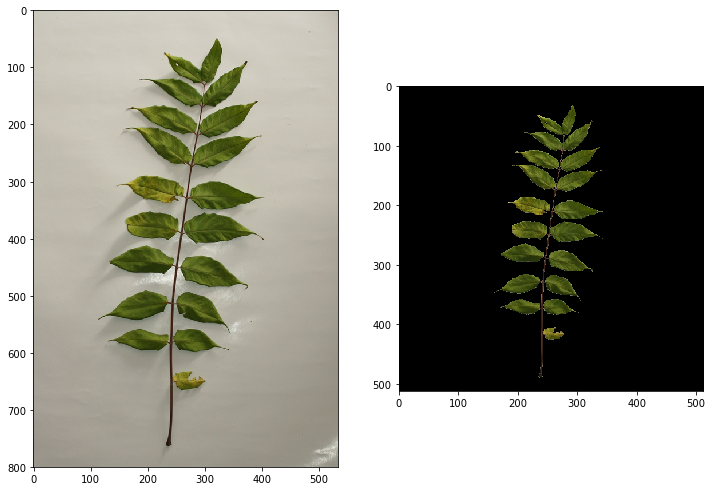

In [14]:
# try changing the input image to test. examples : 5.jpg 197.jpg, 110.jpg, 10006.jpg, 3142.jpg
# (bg substraction fails on this one)
img = skimage.io.imread(os.path.join(TRAIN_PATH, '3142.jpg'))
img = skimage.img_as_float(img)
img_orig = img.copy()
img = extract_background(img)
img = remove_small_objects(img)
img = resize_to_square(img)

pl.figure(figsize=(12, 12))
pl.subplot(121)
pl.imshow(img_orig)
pl.subplot(122)
pl.imshow(img.filled(0), interpolation='nearest')

## Convert all images

In [15]:
# Change the False to True to actually convert all images (this might take some time)
if False:
    OUTDIR = 'data/preprocessed/clef_train_512'

    for fname in sorted(os.listdir(TRAIN_PATH)):
        if fname.endswith('.jpg'):
            basename = os.path.splitext(fname)[0]
            img = skimage.io.imread(os.path.join(TRAIN_PATH, basename + ".jpg"))
            img = skimage.img_as_float(img)
            img_orig = img.copy()
            img = extract_background(img)
            img = remove_small_objects(img)
            img = resize_to_square(img)

            skimage.io.imsave(os.path.join(OUTDIR, basename + ".png"), img.filled(0))
            #np.save(os.path.join(OUTDIR, basename + ".npy"), img.filled(-1))


## Image metadata loading

In [16]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_xml(fname):
    with open(fname) as f:
        tree = ET.parse(f)
        root = tree.getroot()
        content = root.find('Content').text.strip().lower()
        photo_type = root.find('Type').text.strip().lower()
        #plant_id = root.find('IndividualPlantId').text.strip().lower()
        classid = root.find('ClassId').text.strip().lower()
        #print "plant_id : ", plant_id
        #print "content : ", content
        #print "classid : ", classid
        #print "type : ", photo_type

    return content, classid, photo_type

print load_xml(os.path.join(TRAIN_PATH, '4.xml'))
print load_xml(os.path.join(TRAIN_PATH, '5.xml'))

('leaf', 'daphne cneorum', 'scan')
('picked leaf', 'platanus x hispanica', 'photograph')


In [17]:
def load_metadata(basedir):
    rows = []
    columns = ["basename", "content", "classid", "photo_type"]
    for fname in sorted(os.listdir(basedir)):
        if fname.endswith('.jpg'):
            basename = os.path.splitext(fname)[0]
            content, classid, photo_type = load_xml(os.path.join(basedir, basename + ".xml"))
            rows.append((basename, content, classid, photo_type))
    return pd.DataFrame(rows, columns=columns)

train_meta = load_metadata(TRAIN_PATH)
# only select leafs
train_meta = train_meta[train_meta['content'] == 'leaf']
# and only scan and pseudoscan
train_meta = train_meta[train_meta['photo_type'].isin(['scan', 'pseudoscan'])]

### Example 1 - only 9 classes

In [18]:
import os, errno

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

In [19]:
# print sorted(np.unique(train_meta['classid']))
selected_classes = [
    'acer campestre',
    'ailanthus altissima',
    'liquidambar styraciflua',
    'alnus glutinosa',
    'arbutus unedo',
    'castanea sativa',
    'nerium oleander',
    'quercus pubescens',
    'vitex agnus-castus'
]

train_mask = train_meta['classid'].isin(selected_classes)
ex1_meta = train_meta[train_mask]

print ex1_meta.shape

print np.unique(ex1_meta['classid'])

OUTDIR = 'data/preprocessed/'
OUT_IMG_DIR = os.path.join(OUTDIR, 'imgs')

mkdir_p(OUTDIR)
mkdir_p(OUT_IMG_DIR)

for basename in ex1_meta['basename']:
    outfname = os.path.join(OUT_IMG_DIR, basename + ".png")
    if not os.path.exists(outfname):
        img = skimage.io.imread(os.path.join(TRAIN_PATH, basename + ".jpg"))
        img = skimage.img_as_float(img)
        img_orig = img.copy()
        img = extract_background(img)
        img = remove_small_objects(img)
        img = resize_to_square(img)

        skimage.io.imsave(outfname, img.filled(0))
        
# save meta
ex1_meta.to_pickle(os.path.join(OUTDIR, "meta.pkl"))

(583, 4)
['acer campestre' 'ailanthus altissima' 'alnus glutinosa' 'arbutus unedo'
 'castanea sativa' 'liquidambar styraciflua' 'nerium oleander'
 'quercus pubescens' 'vitex agnus-castus']
